In [1]:
from glob import glob
import matplotlib.pyplot as plt

import torch
import torchvision

import align

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = 'cuda'

In [4]:
# load images
burst_name = 'portrait_extreme_noise'
image_file_paths = glob(f'test_images/{burst_name}/*.jpg')
images = []
for path in image_file_paths:
    image = torchvision.io.read_image(path)
    image = image.to(device)
    image = image.to(torch.float16) / 255
    image = torchvision.transforms.functional.resize(image, [1200, 900])
    images.append(image)
images = torch.stack(images)
N, C, H, W = images.shape

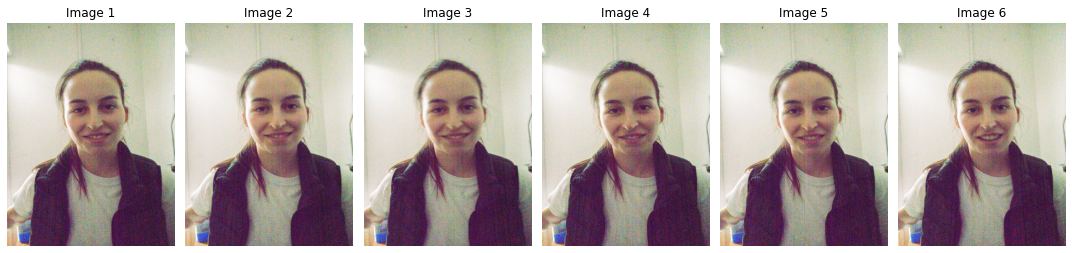

In [5]:
# display all images 
fig, axs = plt.subplots(1, N, figsize=(15, 10))
for i, (image, ax) in enumerate(zip(images, axs)):
    ax.imshow(image.to(torch.float32).to('cpu').permute(1, 2, 0))
    ax.set_title(f'Image {i+1}')
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# split images into 'reference' image and 'comparison'
# images which are to be aligned with the 'reference' image
ref_idx = 0
ref_image = images[ref_idx]
comp_images = images[torch.arange(len(images)) != ref_idx]

In [7]:
%%time
# align images
downscale_factor_list = [1, 2, 2, 2]
tile_shape_list = [[16, 16], [16, 16], [16, 16], [16, 16]]
search_region_list = [[-4, 4], [-4, 4], [-4, 4], [-4, 4]]
aligned_images = align.align_images(ref_image, comp_images,
                    downscale_factor_list, tile_shape_list, search_region_list)

Wall time: 939 ms


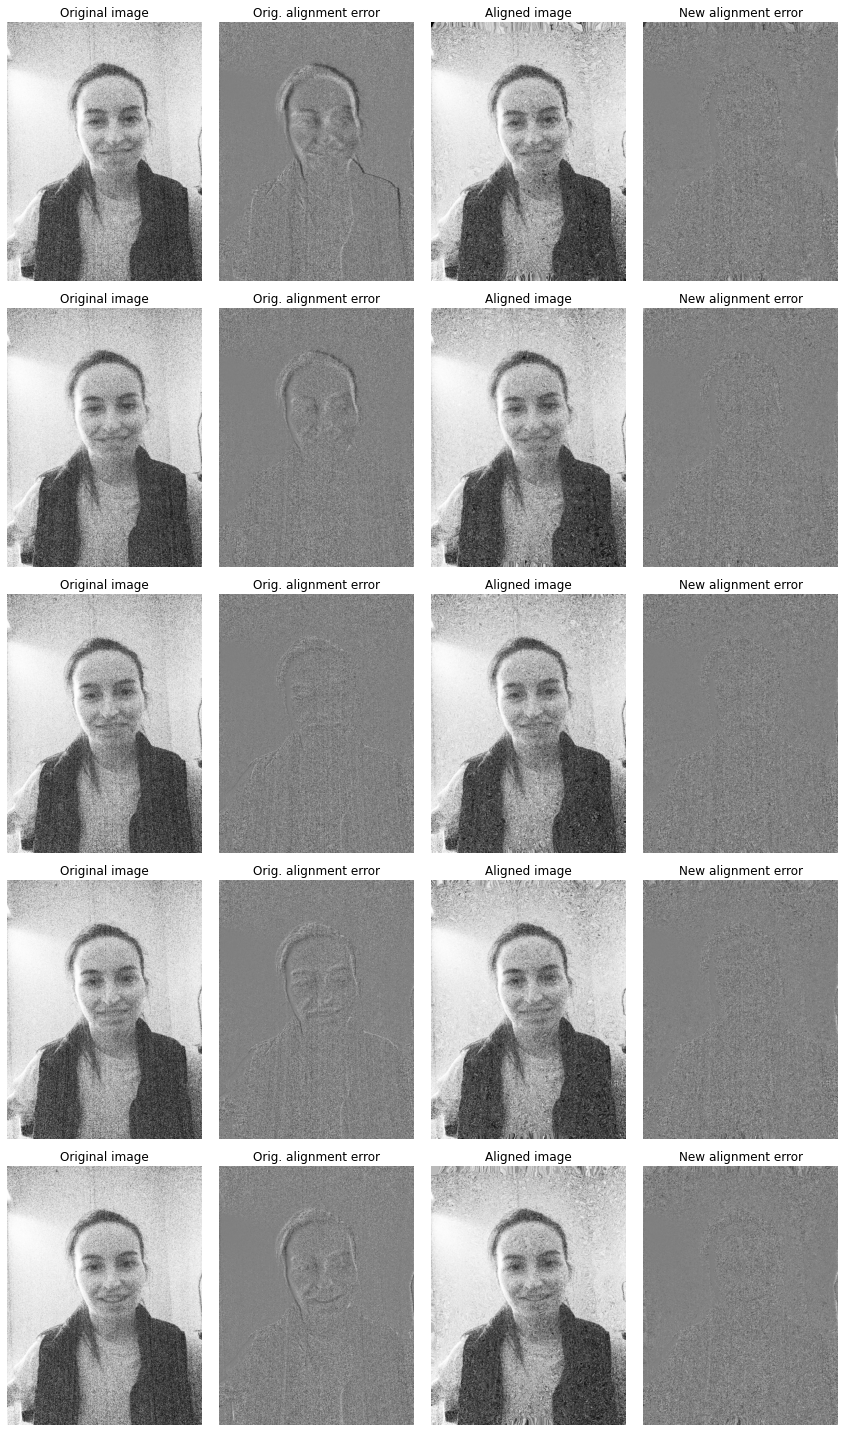

In [8]:
# visualize the aligned images
fig, axs_all = plt.subplots(N-1, 4, figsize=(12, 20))
for y, axs in enumerate(axs_all):
    axs[0].imshow(comp_images[y][0].to('cpu').float(), cmap='gray')
    axs[0].set_title('Original image')
    axs[1].imshow((comp_images[y][0] - ref_image[0]).to('cpu').float(), vmin=-1, vmax=1, cmap='gray')
    axs[1].set_title('Orig. alignment error')
    axs[2].imshow(aligned_images[y][0].to('cpu').float(), cmap='gray')
    axs[2].set_title('Aligned image')
    axs[3].imshow((aligned_images[y][0] - ref_image[0]).to('cpu').float(), vmin=-1, vmax=1, cmap='gray')
    axs[3].set_title('New alignment error')
    for ax in axs:
        ax.set_aspect(1)
        ax.axis('off')
plt.tight_layout()
plt.show()

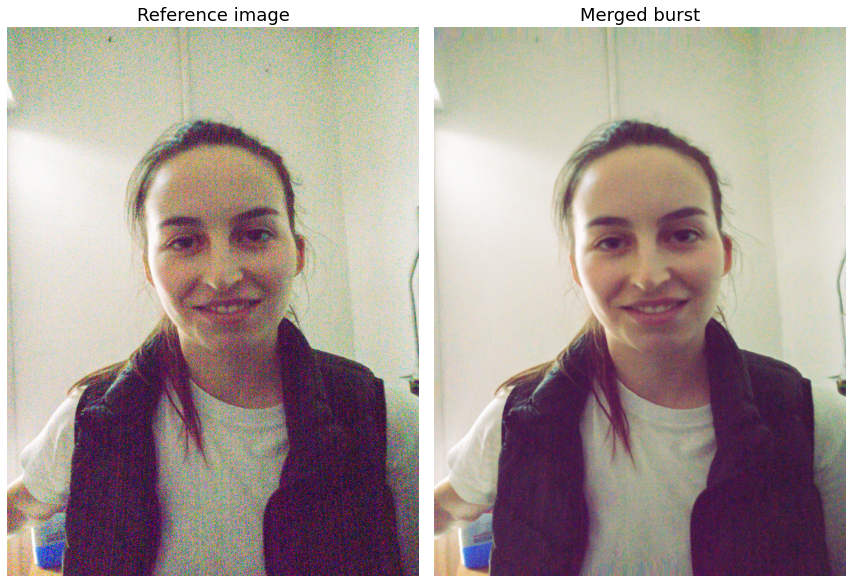

In [9]:
# merge images
# TODO: robust merge
merged_image = ref_image + aligned_images.sum(0)
merged_image /= (1 + len(aligned_images))
merged_image = torch.clip(merged_image, 0, 1)

# plot reference vs. merged image
fig, axs = plt.subplots(1, 2, figsize=[12, 8])
axs[0].imshow(ref_image.to('cpu').float().permute(1, 2, 0))
axs[0].set_title('Reference image', fontsize=18)
axs[1].imshow(merged_image.to('cpu').float().permute(1, 2, 0))
axs[1].set_title('Merged burst', fontsize=18)
for ax in axs:
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'results/{burst_name}.jpg', bbox_inches='tight')
plt.show()